# Lab 10: Explainability with Alibi
In this lab, you'll learn about the Alibi Explain library and implement global and local explanations of tabular and image classification models.

Alibi Explain is an open source Python library aimed at machine learning model inspection and interpretation. The focus of the library is to provide high-quality implementations of black-box, white-box, local and global explanation methods for classification and regression models.

Complete all the Deliverables mentioned below and show it to a TA for credit.

## Deliverables
- Finish all the TODOs in Section 2
- Generate PD Plots. Discuss your findings about model performance with the TA and answer Q1, Q2, and Q3:
     - Q1: Which features have higher importance in the prediction? (Section 2.1)
     - Q2: What can you conclude with the PD plots? (Section 2.2)
     - Q3: Discuss with the TA the results (heatmaps). (Section 2.2)
- Show final results  about the Anchor parameters and discuss them with the TA.
- Complete the SHAP section & discuss your findings with the TA.


## Getting Started
Clone this repository and run all cells in the notebook.

### Install Dependencies

For this assignment, make sure you have the required packages installed.
```
pip install -r requirements.txt
```
(If there are any major unsolvable issues prefer running this notebook on Google Colaboratory)

### Possible Issues with installing Alibi
`TypeError: issubclass() arg 1 must be a class` \
**Solution:** https://stackoverflow.com/questions/76313592/import-langchain-error-typeerror-issubclass-arg-1-must-be-a-class
<br><br>
If there's any more issues, please contact a TA to update this list (with a solution if its solved)

In [43]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from alibi.explainers import PartialDependence, plot_pd, plot_pd_variance
from alibi.explainers import PartialDependenceVariance


## Section 1 - Data + Modeling
In this section, we will be setting up our data, perform some preprocessing and train a model.

### 1.1 Fetching the Dataset
We are going to use the The Boston Housing Dataset in the next experiment.
https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html


There are 14 attributes in each case of the dataset:
- CRIM - per capita crime rate by town
- ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS - proportion of non-retail business acres per town.
- CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
- NOX - nitric oxides concentration (parts per 10 million)
- RM - average number of rooms per dwelling
- AGE - proportion of owner-occupied units built prior to 1940
- DIS - weighted distances to five Boston employment centres
- RAD - index of accessibility to radial highways
- TAX - full-value property-tax rate per $10,000
- PTRATIO - pupil-teacher ratio by town
- B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
- LSTAT - % lower status of the population
- MEDV - Median value of owner-occupied homes in $1000's

In [44]:
df = pd.read_csv('BostonHousing.csv')
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


### 1.2 Dataset Preprocessing

Run the following code necessary to pre-process the data for alibi.

In [45]:
# extract feature names
feature_names = df.columns.tolist()
target_feature = 'medv'
feature_names.remove(target_feature)

# define target names
target_names = [target_feature]

#  define categorical columns
categorical_columns_names = []

# define categorical and numerical indices for later preprocessing
categorical_columns_indices = [feature_names.index(cn) for cn in categorical_columns_names]
numerical_columns_indices = [feature_names.index(fn) for fn in feature_names if fn not in categorical_columns_names]

# extract data
X = df[feature_names]
# define target column
y = df[target_feature]

# split data in train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [46]:
# define and fit the original encoder
oe = OrdinalEncoder().fit(X_train[categorical_columns_names])

# transform the categorical columns to ordinal encoding
X_train.loc[:, categorical_columns_names] = oe.transform(X_train[categorical_columns_names])
X_test.loc[:, categorical_columns_names] = oe.transform(X_test[categorical_columns_names])

# convert data to numpy
X_train, y_train = X_train.to_numpy(), y_train.to_numpy()
X_test, y_test = X_test.to_numpy(), y_test.to_numpy()

# define categorical mappings
categorical_names = {i: list(v) for (i, v) in zip(categorical_columns_indices, oe.categories_)}

In [47]:
# define numerical standard sclaer
num_transf = StandardScaler()

# define categorical one-hot encoder
cat_transf = OneHotEncoder(
    categories=[range(len(x)) for x in categorical_names.values()],
    handle_unknown='ignore',
)

# define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transf, categorical_columns_indices),
        ('num', num_transf, numerical_columns_indices),
    ],
    sparse_threshold=0
)


In [48]:
# fit preprocessor
preprocessor.fit(X_train)

# preprocess train and test datasets
X_train_ohe = preprocessor.transform(X_train)
X_test_ohe = preprocessor.transform(X_test)

### 1.3 Training the Model
Run the cell to fit the model to the dataset

In [49]:
# define and fit regressor - feel free to play with the hyperparameters
predictor = RandomForestRegressor(random_state=0)
predictor.fit(X_train_ohe, y_train)

# compute scores
print('Train score: %.2f' % (predictor.score(X_train_ohe, y_train)))
print('Test score: %.2f' % (predictor.score(X_test_ohe, y_test)))

Train score: 0.98
Test score: 0.77


## Section 2 - Explainability with Alibi
In this section, we will be finally using Alibi to explain our trained model using different techniques. Fill in the TODOs and generate plots where required.

In [50]:
# Creating a Prediction Function - Includes pipeline from preprocessing to prediction
prediction_fn = lambda x: predictor.predict(preprocessor.transform(x))

#### Computing Explanations
We will finally be computing explanations for selected features. Play around with different methods.

### 2.1 Partial Dependence Variance (PDV)  - Feature Importance

Partial Dependence Variance is a method to compute the global feature importance or the feature interaction of a pair of features.

Complete the code below and answer Q1

**Q1: Which features have higher importance in the prediction?**

In [51]:
# TODO: Determine which features are more important
# suggestion: Use PartialDependenceVariance class and explain function using the argument method='importance'

# What Partial dependence variance is: a way to measure globally the feature importance and the strength of the feature interactions between pairs of features

#explainer = ...
explainer = PartialDependenceVariance(
    predictor=prediction_fn,
    feature_names=feature_names,
    categorical_names=categorical_names,
    target_names=target_names
)

exp_importance = exp_importance = explainer.explain(
    X=X_train,
    method='importance' # for global importance
)


array([[<Axes: title={'center': 'medv'}, xlabel='Feature importance'>]],
      dtype=object)

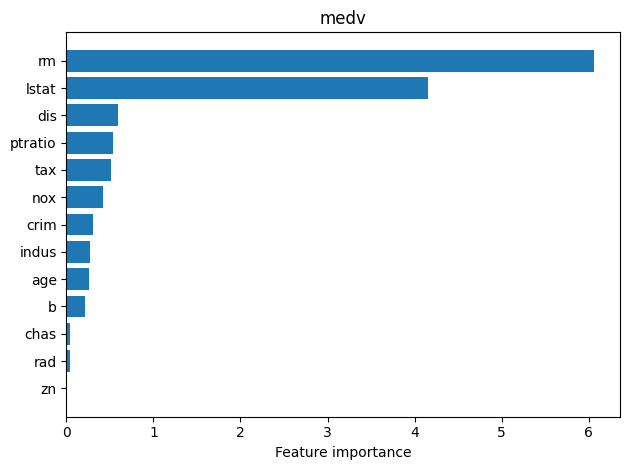

In [52]:
# plot the results using 
plot_pd_variance(exp=exp_importance)

array([[<Axes: title={'center': 'imp(rm) = 6.057'}, xlabel='rm', ylabel='medv'>,
        <Axes: title={'center': 'imp(lstat) = 4.159'}, xlabel='lstat', ylabel='medv'>,
        <Axes: title={'center': 'imp(dis) = 0.589'}, xlabel='dis', ylabel='medv'>],
       [<Axes: title={'center': 'imp(ptratio) = 0.533'}, xlabel='ptratio', ylabel='medv'>,
        <Axes: title={'center': 'imp(tax) = 0.509'}, xlabel='tax', ylabel='medv'>,
        <Axes: title={'center': 'imp(nox) = 0.424'}, xlabel='nox', ylabel='medv'>],
       [<Axes: title={'center': 'imp(crim) = 0.311'}, xlabel='crim', ylabel='medv'>,
        <Axes: title={'center': 'imp(indus) = 0.267'}, xlabel='indus', ylabel='medv'>,
        <Axes: title={'center': 'imp(age) = 0.263'}, xlabel='age', ylabel='medv'>],
       [<Axes: title={'center': 'imp(b) = 0.211'}, xlabel='b', ylabel='medv'>,
        <Axes: title={'center': 'imp(chas) = 0.047'}, xlabel='chas', ylabel='medv'>,
        <Axes: title={'center': 'imp(rad) = 0.042'}, xlabel='rad', yla

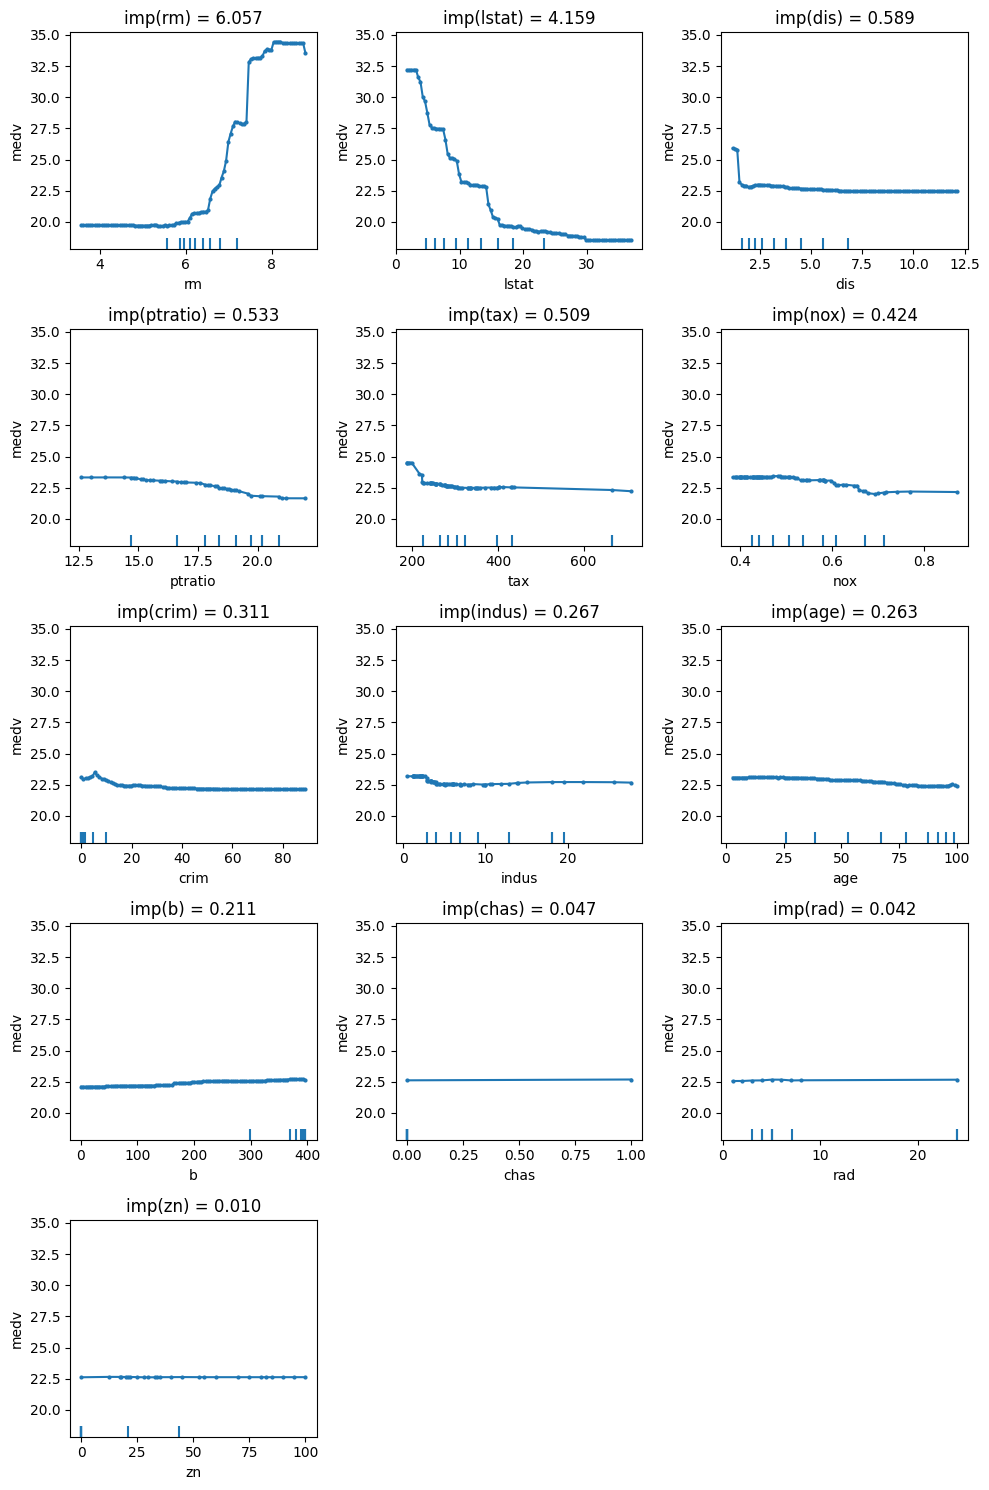

In [53]:
plot_pd_variance(exp=exp_importance, summarise=False,  fig_kw={'figheight': 15, 'figwidth': 10})

14 attributes in each case of the dataset:
- CRIM - per capita crime rate by town
- ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS - proportion of non-retail business acres per town.
- CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
- NOX - nitric oxides concentration (parts per 10 million)
- RM - average number of rooms per dwelling
- AGE - proportion of owner-occupied units built prior to 1940
- DIS - weighted distances to five Boston employment centres
- RAD - index of accessibility to radial highways
- TAX - full-value property-tax rate per $10,000
- PTRATIO - pupil-teacher ratio by town
- B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
- LSTAT - % lower status of the population
- MEDV - Median value of owner-occupied homes in $1000's

## **Insights:**
### **Images:**
* The model’s predictions are driven mainly by **how big the homes are** (number of rooms - **RM**) and **how wealthy or disadvantaged the neighborhood is** (LSTAT). These two factors outweigh everything else by a large margin.
* The strong jump in predicted house value when RM increases shows the model believes **adding space has a disproportionately positive effect**, especially once homes reach a certain size (around 6–7 rooms).
* The steep drop with LSTAT reveals the model has learned that **neighborhood socioeconomic status heavily shapes home prices**, and small changes in LSTAT matter a lot in lower-LSTAT areas.
* Other features like pollution (NOX), taxes, and pupil–teacher ratio matter, but their influence is minor — **they fine-tune predictions rather than drive them.**
* Features such as zoning rules, proximity to radial highways, and whether the house borders the river barely matter — the model treats them as **noise or background details** with little predictive value.
> Overall, the model is effectively saying: **“Bigger homes in wealthier neighborhoods dominate nearly everything else when predicting house prices.”**

### 2.2 Partial Dependence (PD)

Partial Dependence is a method to visualize the marginal effect that one or two features have on the predicted outcome of a machine learning model.

By inspecting the PD plots, one can understand whether the relation between a feature/pair of features is, for example, a simple linear or quadratic relation, whether it presents a monotonically increasing or decreasing trend, or reveal a more complex response.

#### Computing Explanations
We will finally be computing explanations. You can try different modes of `kind` to see different visualizations. (Suggestion: use `both` to visualize all data)

As per the documentation,
> `kind` - If set to `average`, then only the partial dependence (PD) averaged across all samples from the dataset is returned. If set to `individual`, then only the individual conditional expectation (ICE) is returned for each individual from the dataset. Otherwise, if set to `both`, then both the PD and the ICE are returned.


Run the following code with all features and also selecting some specific features.

**Q2: What can you conclude?**

In [54]:
# Define explainer
explainer_pd = PartialDependence(predictor=prediction_fn,
                       feature_names=feature_names,
                       categorical_names=categorical_names,
                       target_names=target_names)


In [55]:
# you can also compute explanations for selected features.
# Hint - Select Column Indices = feature_names.index("COLUMN_NAME")
# zn	indus	chas	nox	rm	age	dis	rad	tax	ptratio	b	lstat	medv

# TODO - Select features you wish to compute explanations for
# Hint - Select Column Indices = feature_names.index("COLUMN_NAME")
features = [
    feature_names.index('lstat'),
    feature_names.index('rm'),
    feature_names.index('nox'),
    feature_names.index('dis'),
]

### **Reason for Selecting the Four Features**

* **LSTAT** and **RM** were selected because the model clearly relies on them the most; they capture the two biggest real-world drivers of value: *who lives in the neighborhood* and *how large the homes are*.
* **NOX** was included because it represents environmental quality, which often shapes prices in subtle but meaningful ways and helps illustrate how the model handles non-linear environmental effects.
* **DIS** was chosen because it captures the tension between *city proximity* and *suburban distance*, giving insight into how location convenience affects the model’s predictions.
> Together, these four features give a **well-rounded, meaningful slice** of the model’s reasoning — covering structural, environmental, socioeconomic, and spatial factors.

array([[<Axes: xlabel='lstat', ylabel='medv'>,
        <Axes: xlabel='rm', ylabel='medv'>,
        <Axes: xlabel='nox', ylabel='medv'>,
        <Axes: xlabel='dis', ylabel='medv'>]], dtype=object)

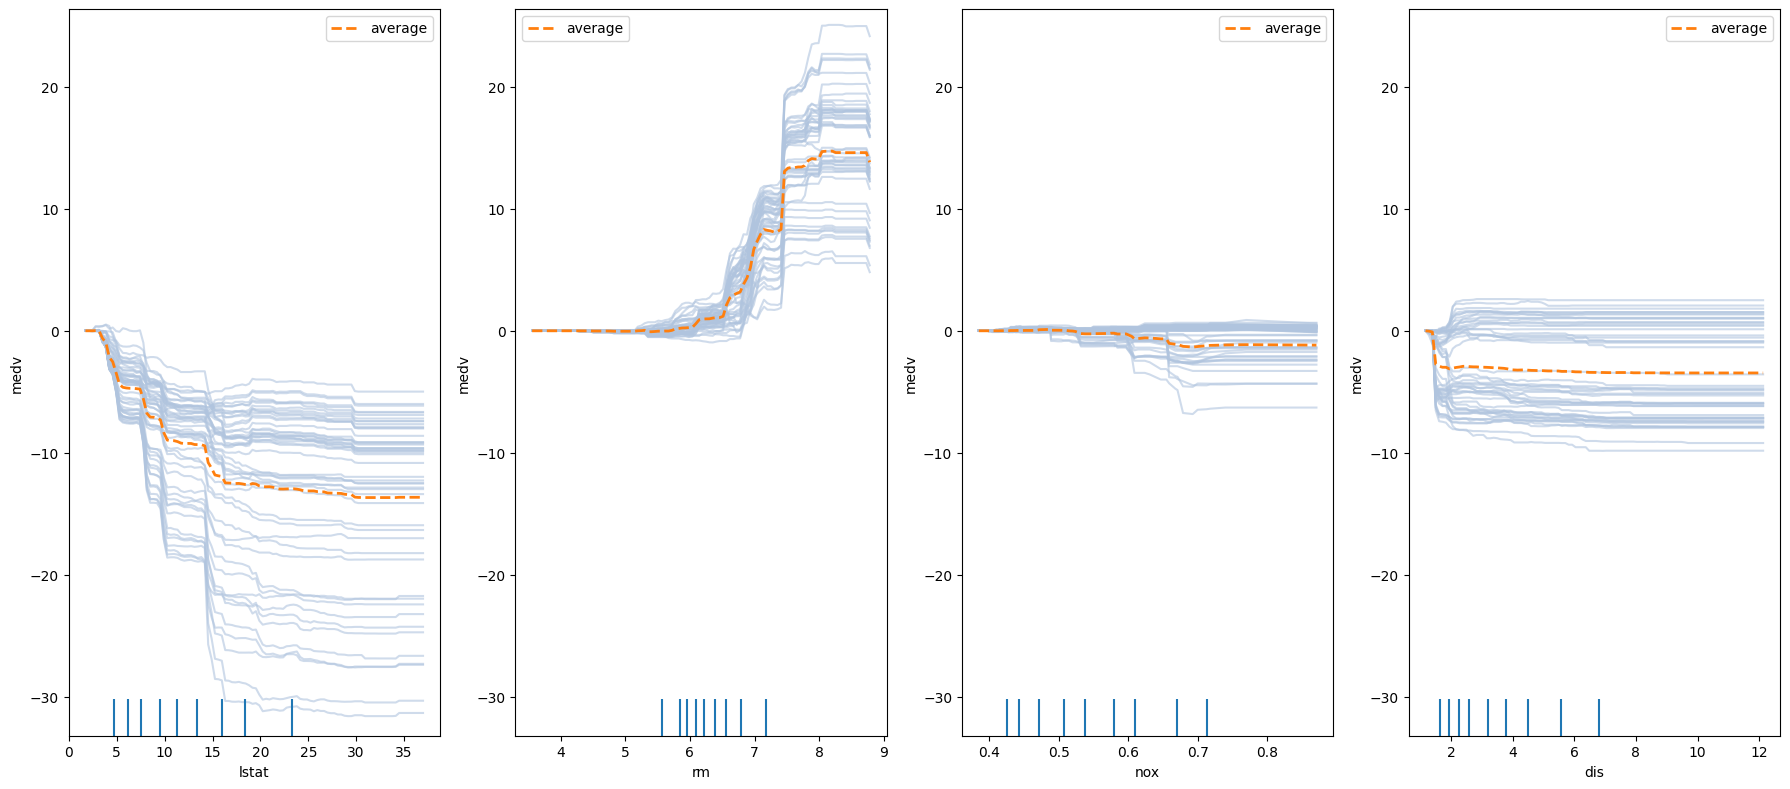

In [56]:
# compute explanations for these features (both PD and ICE)
exp = explainer_pd.explain(X=X_train,
                        features=features,
                        # kind='individual')
                        # kind='average') 
                        kind='both') # kind = [both, individual, average]


# # plot partial dependece curves
# # this setup should work for any mode of kind, feel free to alter this to better suit your plot view.
plot_pd(exp=exp,
        n_cols=4,
        n_ice=50,
        sharey='row',
        center = True,
        fig_kw={'figheight': 8, 'figwidth': 18})

### **Insights:**
* The model treats **LSTAT** as a heavy penalty: small increases in % lower-status residents reliably drive predictions down, and that drop is sharp for many individual cases.
* **RM** behaves like a size threshold: once houses reach about 6–7 rooms the predicted value jumps noticeably, though individual homes gain different amounts.
* **NOX** is a mild negative nudger — higher pollution slightly lowers predictions but doesn’t change them much for most houses.
* **DIS** (distance) has the most mixed effect: for some homes being farther out reduces value a lot, for others it barely matters — its influence depends on the house’s other characteristics.
> Bottom line: this image shows the model strongly trusts neighborhood wealth and house size, treats pollution as a small correction, and uses distance inconsistently depending on context.

### Check Partial Dependence for Two Features
Choose pairs of features to visualize their relationships and interactions with each other. These plots may be a bit confusing so try your best to explain whatever you understand to the TA.
We suggest to select a feature with high  and low importance. 
You can also try different combinations of features in order to get better conclusion.

**Q3: Discuss with the TA the results.**

In [57]:
# TODO: select combination of features
FEATURE1 = 'rm'       # high importance
# FEATURE2 = 'chas'     # very low importance
FEATURE2 = 'lstat' # for test purposes

# RM strongly shapes the model’s predictions, while CHAS contributes almost nothing

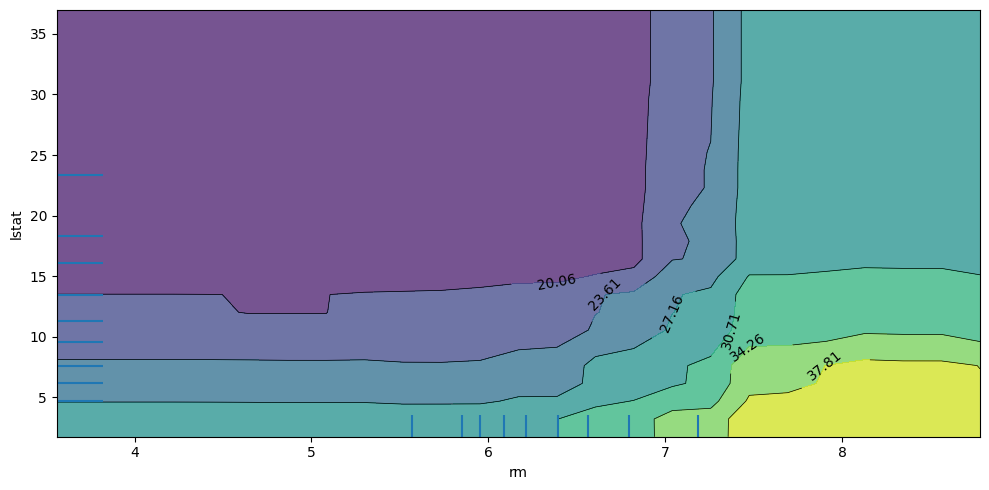

In [58]:
combined_features = [(feature_names.index(FEATURE1), feature_names.index(FEATURE2))]

# compute explanations
comb_exp = explainer_pd.explain(X=X_train,
                        features=combined_features,
                        kind='average',
                        grid_resolution=25) # kind = [both, individual, average]

# plot partial dependece curves
plot_pd(exp=comb_exp,
        n_cols=3,
        n_ice=50,
        sharey='row',
        center = True,
        fig_kw={'figheight': 5, 'figwidth': 10});


### **Insights:**
* **Using RM vs CHAS:** The RM–CHAS interaction plot shows that predicted prices change dramatically with the number of rooms, but remain completely unaffected by the CHAS river indicator, meaning the model has learned that home size matters and CHAS simply doesn’t.
* **Using RM vs LSTAT:** The RM–LSTAT surface shows a strong interaction: room count boosts price only in wealthier areas, while high LSTAT flattens everything and keeps predictions low regardless of how large the home is.

## 2.3 Anchors
This algorithm provides model-agnostic (black box) and human interpretable explanations suitable for classification models applied to images, text and tabular data. The idea behind anchors is to explain the behaviour of complex models with high-precision rules called anchors. These anchors are locally sufficient conditions to ensure a certain prediction with a high degree of confidence. Run all the cells and try different parameters to see how this algorithm works.

We will be explaining predictions from the ImageNet model on the cats dataset.

In [59]:
import tensorflow as tf
import matplotlib

import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from alibi.datasets import load_cats
from alibi.explainers import AnchorImage

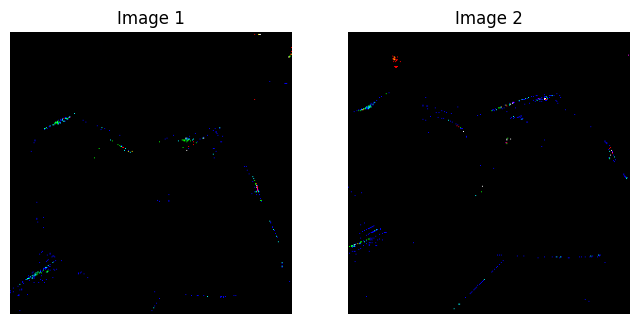

In [60]:
# Path to your image

# You are free to play around with other images. 
# Here are two pictures of Professor Bogdan's beautiful cat.
img1_path = "hyPURRmeter_fineMEOWing.jpg"
img2_path = "your_TA.jpg"

def load_and_preprocess(img_path):
    img = image.load_img(img_path, target_size=(299, 299))
    img_array = image.img_to_array(img)
    img_preprocessed = preprocess_input(np.expand_dims(img_array, axis=0))
    return img_array, img_preprocessed

# Load and preprocess
img1 = image.load_img(img1_path, target_size=(299, 299))
img1_array = image.img_to_array(img1)
img1_preprocessed = preprocess_input(np.expand_dims(img1_array, axis=0))

img2 = image.load_img(img2_path, target_size=(299, 299))
img2_array = image.img_to_array(img2)
img2_preprocessed = preprocess_input(np.expand_dims(img2_array, axis=0))

# Display both images
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(img1_array.astype('uint8'))
plt.title("Image 1")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img2_array.astype('uint8'))
plt.title("Image 2")
plt.axis('off')
plt.show()


**Note:** Both images have now been resized and preprocessed so the model sees them in a consistent, comparable way, and this prepares them for anchor explanations. This step also confirms the inputs are valid and free of distortions before we analyze anything further. Since the images differ in lighting, pose, and background, the model may focus on different regions in each one, and the next step will reveal which specific superpixels it considers sufficient for its predictions.

In [61]:
#load pre-trained model
model = InceptionV3(weights='imagenet')
predict_fn = lambda x: model.predict(x)

In [ ]:
#check model predictions for both images.
for idx, (arr, prep) in enumerate([(img1_array, img1_preprocessed), (img2_array, img2_preprocessed)], start=1):
    preds = model.predict(prep)
    decoded = decode_predictions(preds, top=3)[0]
    print(f"\nTop predictions for Image {idx}:")
    for _, label, prob in decoded:
        print(f"  {label:20s}: {prob:.3f}")

1/1 [==============================] - 1s 1s/step

Top predictions for Image 1:
  Persian_cat         : 0.502
  Siamese_cat         : 0.139
  carton              : 0.055
1/1 [==============================] - 0s 97ms/step

Top predictions for Image 2:
  Persian_cat         : 0.574
  Siamese_cat         : 0.157
  crate               : 0.008


In [63]:
#create and run anchorImage explainer
image_shape = (299, 299, 3)
segmentation_fn = 'slic'  # Superpixel segmentation
kwargs = {'n_segments': 15, 'compactness': 20, 'sigma': .5, 'start_label': 0}


In [64]:
explainer = AnchorImage(
    predict_fn,
    image_shape=image_shape,
    segmentation_fn=segmentation_fn,
    segmentation_kwargs=kwargs,
    images_background=None
)


1/1 [==============================] - 0s 99ms/step


In [65]:
#choose an image to explain - Image 1

image_to_explain = img1_preprocessed[0]
np.random.seed(0)

explanation = explainer.explain(image_to_explain, threshold=.95, p_sample=.5, tau=0.25)


4/4 [==============================] - 5s 1s/step


(-0.5, 298.5, 298.5, -0.5)

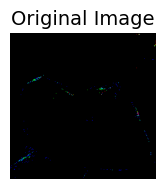

In [66]:
plt.subplot(1, 3, 1)
plt.imshow(img1_array.astype('uint8'))
plt.title("Original Image", fontsize=14)
plt.axis('off')


(-0.5, 298.5, 298.5, -0.5)

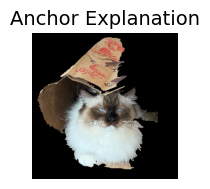

In [67]:
plt.subplot(1, 3, 2)
plt.imshow(explanation.anchor)
plt.title("Anchor Explanation", fontsize=14)
plt.axis('off')

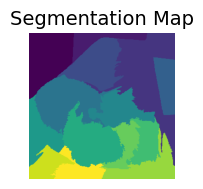

In [68]:
plt.subplot(1, 3, 3)
plt.imshow(explanation.segments)
plt.title("Segmentation Map", fontsize=14)
plt.axis('off')
plt.show()

### **Insights:**
**What the Anchor Shows:** The anchor explanation identifies the smallest region of the image the model needs to remain confident in its prediction.

**Where the Model Focuses:** The model primarily relies on the animal’s face and surrounding fur, using details like shape, texture, and color patterns to make its decision.

**What the Segmentation Means:** The image is first broken into texture-based segments, and the anchor selects only the segments that truly influence the model’s output.

**Why This Matters:** The model ignores the background and unimportant regions, showing that it is attending to meaningful features. This helps reveal *what convinced the system to make its classification* and supports trust in its behavior.


In [69]:
#choose an image to explain - Image 2

image_to_explain = img2_preprocessed[0]
np.random.seed(0)

explanation = explainer.explain(image_to_explain, threshold=.95, p_sample=.5, tau=0.25)


4/4 [==============================] - 5s 1s/step


(-0.5, 298.5, 298.5, -0.5)

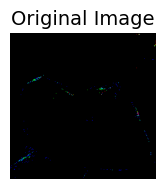

In [70]:
plt.subplot(1, 3, 1)
plt.imshow(img1_array.astype('uint8'))
plt.title("Original Image", fontsize=14)
plt.axis('off')


(-0.5, 298.5, 298.5, -0.5)

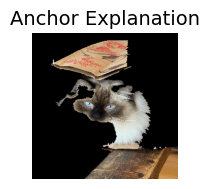

In [71]:
plt.subplot(1, 3, 2)
plt.imshow(explanation.anchor)
plt.title("Anchor Explanation", fontsize=14)
plt.axis('off')

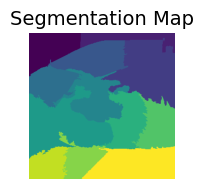

In [72]:
plt.subplot(1, 3, 3)
plt.imshow(explanation.segments)
plt.title("Segmentation Map", fontsize=14)
plt.axis('off')
plt.show()

### **Insights:**
**What the Anchor Shows:** The anchor explanation identifies the smallest region of the image the model needs to stay confident in its prediction.

**Where the Model Focuses:** In this second image, the model relies mainly on the animal’s face—especially the eyes, facial outline, nearby fur, and even a small part of the object above the head—because these patterns are strong signals for its classification.

**What the Segmentation Means:** The image is first broken into small texture-based segments, and the anchor selects only the segments whose presence keeps the model’s prediction stable.

**Why This Matters:** The model is paying attention to the central subject rather than the background, and only a small region is enough for it to maintain its decision. This helps reveal what convinced the system to choose its answer and offers a quick check that it is using the right parts of the image.


**Are both insights for the images the same?**

**No:** 
- Both anchor explanations show that the model consistently relies on the animal’s face and surrounding fur to stay confident in its prediction. 
- They differ because the second image **includes additional reliance on nearby objects and reflections around the eyes**, revealing slightly different cues the model uses depending on the scene.


Questions:
1. What part of your image did the Anchor explainer focus on?
> **Answer:** It focused on the **central region** of the animal, mainly the **face, eyes, and surrounding fur**, along with a small portion of the object above it.
2. Does the highlighted region make sense when you compare it to the model's predicted label?
> **Answer:** Yes, those areas contain the key visual features the model relies on (shape, texture, color patterns) -- which means they strongly influence the prediction
3. What does it mean if the highlighted region seems unrelated to the object?
> **Answer:** It suggests the model may be using the wrong cues, like background textures or random objects, which can show bias, shortcuts, or potential reliability problems in how the model makes decisions.


## 3 SHAP
SHAP is a unified framework for interpreting predictions based on Shapley values from cooperative game theory.
It attributes the prediction of a model to each input feature by quantifying how much that feature contributed to increasing or decreasing the final prediction compared to the model’s average output.
In other words, SHAP tells us:
“If I remove or change this feature, how would the model’s prediction change?”
SHAP values are additive, meaning that for each prediction, the sum of all feature contributions equals the model’s output minus the baseline (average) prediction.
This makes SHAP both mathematically grounded and visually interpretable.
In this section, you will:
1. Generate global feature importance using SHAP summary plots.
2. Analyze local explanations for a specific instance using waterfall plots.
3. Compare SHAP’s results with your earlier Partial Dependence and Anchor explanations to see whether they agree.

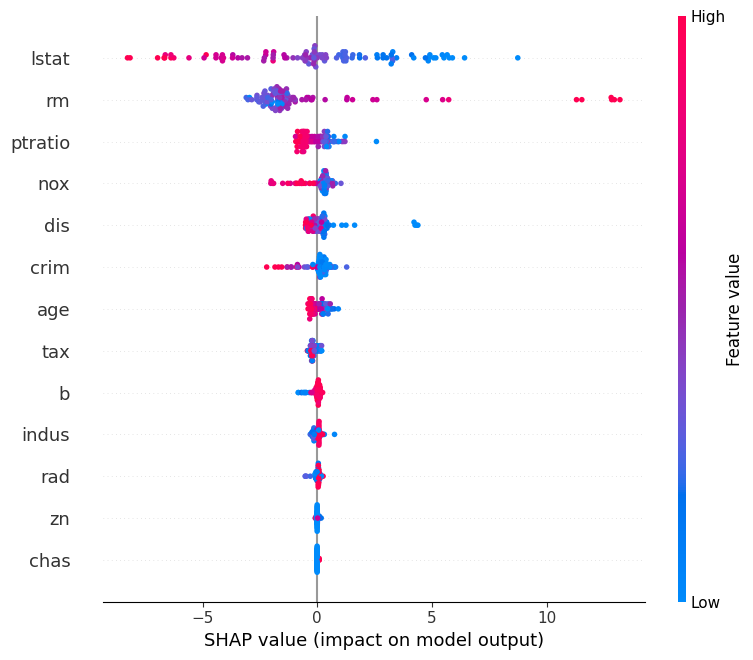

In [74]:
import shap
import matplotlib.pyplot as plt

# Define SHAP explainer for the Random Forest regressor
shap_explainer = shap.Explainer(predictor, X_train_ohe)

# Compute SHAP values
shap_values = shap_explainer(X_test_ohe)

# Global feature importance
shap.summary_plot(shap_values, X_test, feature_names=feature_names)
# plt.title("Global SHAP Feature Importance")
# plt.show()


### **Insights: Global SHAP Summary Plot (Scatter Plot)**

This plot shows which features matter most across the entire dataset.

* **LSTAT**, **RM**, and **PTRATIO** have the largest overall impact on predictions.
* Red points (high feature values) and blue points (low values) show how each feature pushes the prediction higher or lower.
* For example, **high LSTAT** tends to **lower** predicted house prices, while **more rooms (RM)** tends to **increase** them.
* Overall, the plot reveals the model’s main drivers and how feature values influence the output direction.


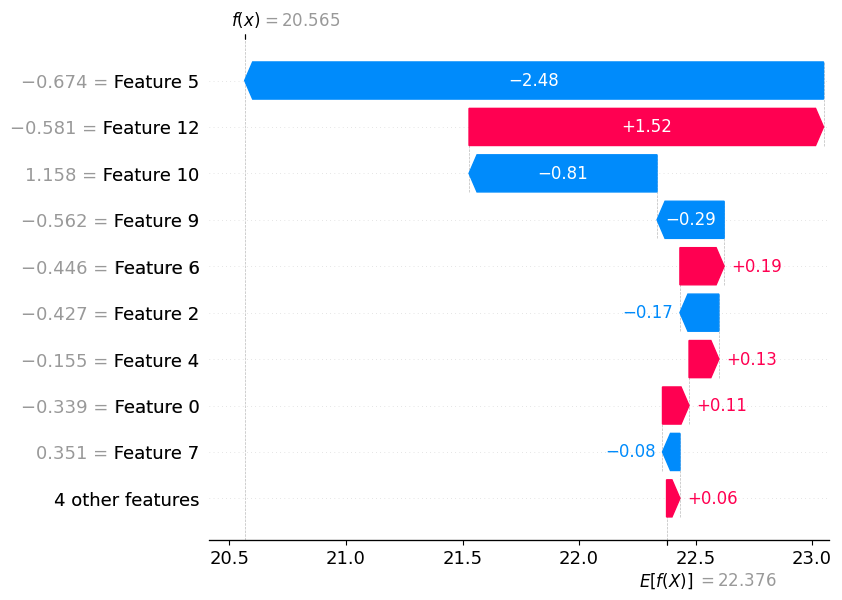

In [75]:
# Local explanation for one instance
idx = 5
shap.plots.waterfall(shap_values[idx])

### **Insights: Local SHAP Waterfall Plot (Single Instance)**

This shows why the model made a specific prediction for one selected example.

* The baseline (average prediction) is shown on the left.
* Each feature either **pulls the prediction up** (pink/red bars) or **pulls it down** (blue bars).
* For this particular instance, a few strong negative contributors dominate (e.g., Feature 5, Feature 10), reducing the final prediction below the expected average.
* Positive contributors (e.g., Feature 12) push the prediction upward but not enough to offset the negatives.

> **Overall:** 
> - The global plot shows which features the model relies on overall
> - The waterfall plot shows exactly how individual features combined to produce a single prediction.


## 4 Reflection & comparison
You have now explored three complementary ways to understand your model’s behavior:
Partial Dependence (PD): shows average feature effects (global trend).
Anchors: provides human-readable rules explaining specific predictions (local).
SHAP: quantifies feature contributions for each prediction (both global and local).
Each method offers a different lens:
1. PD plots summarize what the model learns overall,
2. Anchors explain why a single decision was made, and
3. SHAP connects both by showing how much each feature contributed numerically.
Use this final section to connect the dots between them.

Questions to answer:

1. Do any of the top features raise ethical or fairness concerns?
Could the model be relying on socioeconomic or location-based variables in ways that might bias predictions?

> **Answer:** Yes:
> - Features such as **LSTAT (percentage of lower-income residents)** and **location-driven** variables like NOX can add **socioeconomic and geographic inequalities** into the predictions. 
> - If the model relies heavily on these, it may unintentionally **reproduce patterns** where lower-income or certain neighborhoods are consistently undervalued.

2. Do SHAP’s most important features agree with those found by PD plots or Anchor explanations?
If they differ, why might that happen?

> **Answer:** 
> - Yes as LSTAT and RM consistently appear as the strongest drivers. 
> - Differences could occur because Partial Dependence (PD) shows average **global** trends, while SHAP also captures **local**, instance-specific interactions (making SHAP more sensitive to how features behave in combination). 
> - Anchors focus strictly on the minimal set of local conditions for a single prediction, so they might highlight a different subset even if the overall importance aligns.

3. Write a short paragraph (3 sentences max) summarizing what your model relies on and how confident you are in its interpretability.

> **Answer:** 
> - The model **mostly depends** on features like LSTAT, and RM, and both methods agree that these strongly shape predictions. 
> - The explanations are **not so easy** to understand for a beginner like me, however, they seem consistent, although some features could raise fairness concerns. 
> - Overall, I feel confident in how the model works, but I would still keep an eye on location-related variables to avoid unintended bias.


### References
1. https://docs.seldon.io/projects/alibi/en/stable/examples/pdp_regression_bike.html
2. https://docs.seldon.io/projects/alibi/en/stable/methods/PartialDependence.html
3. https://docs.seldon.io/projects/alibi/en/stable/examples/anchor_image_imagenet.html
